In [16]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [17]:
import gc
gc.collect()

7240

In [18]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Tue Apr  2 19:36:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8              16W / 250W |    196MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [19]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [20]:
env_id = "CartPole-v1"
# env = make_vec_env(env_id, n_envs=1)
# /mnt/nfs/work/c98181/RL/CartPole-v1/dataset
observations= np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_actions.npy", allow_pickle=True)
rewards = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_rewards.npy", allow_pickle=True)
dones = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_dones.npy", allow_pickle=True)
info = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_info.npy", allow_pickle=True)
next_obs = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()

# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])

# print(actions)

(28000, 4) (28000,) (28000,) (28000,) (28000,) (28000, 4)
[-0.0455423  -0.00493775  0.01715994  0.02859923] 0 1.0 False {'TimeLimit.truncated': False} [-0.04564106 -0.20030153  0.01773192  0.32664654]


In [21]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [22]:
# import numpy as np
# import gymnasium as gym
# from imitation.policies.serialize import load_policy
# from imitation.util.util import make_vec_env
# from imitation.data.wrappers import RolloutInfoWrapper
# env = make_vec_env(
#     "seals:seals/CartPole-v0",
#     rng=np.random.default_rng(),
#     post_wrappers=[
#         lambda env, _: RolloutInfoWrapper(env)
#     ],  # needed for computing rollouts later
# )
# from stable_baselines3.common.evaluation import evaluate_policy

# # reward, _ = evaluate_policy(expert, env, 10)
# print(reward)

In [23]:
policy_network = PolicyNetwork(
    4, 2).to(device)

nn.init.kaiming_normal_(policy_network.fc1.weight)
nn.init.kaiming_normal_(policy_network.fc2.weight)
nn.init.kaiming_normal_(policy_network.fc3.weight)
prev = PolicyNetwork(
    4, 2).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.0017601048183920826,weight_decay=2.350251568550711e-5)
env=make_vec_env_sb3(env_id, n_envs=1)

# Training loop
num_epochs = 1
batch_size = 16

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = 500
num_test = 10
prev_load_freq = 1
now_log=0
now_pos=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        model_dist = Categorical(logits=logits)
        model_act_sample = model_dist.sample()
        policy_chosen_logps = model_dist.log_prob(act_batch)
        policy_rejected_logps = model_dist.log_prob(model_act_sample)
        with torch.no_grad():
            prev_dist = Categorical(logits=prev(obs_batch))
            reference_chosen_logps = prev_dist.log_prob(act_batch)
            reference_rejected_logps = prev_dist.log_prob(model_act_sample)
        # print all logps
        # print("policy_chosen_logps",policy_chosen_logps.detach().mean().item())
        # print("policy_rejected_logps",policy_rejected_logps.detach().mean().item())
        # print("reference_chosen_logps",reference_chosen_logps.detach().mean().item())
        # print("reference_rejected_logps",reference_rejected_logps.detach().mean().item())

        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps
        # print("pi_logratios",pi_logratios.detach().mean().item())
        # print("ref_logratios",ref_logratios.detach().mean().item())
        # chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        # reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

        logits = pi_logratios - ref_logratios
        # print("logits",logits.detach().mean().item())

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps

        # logits = chosen_logratios - reject_logratios

        if epoch <= -1:
          loss = - (policy_chosen_logps).mean()
        else:
          beta = 1
          losses = (-F.logsigmoid(beta * logits))
          loss = losses.mean()
        #   losses = torch.cat((1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)), 1 - F.logsigmoid(beta * (chosen_KL - reject_logratios))), 0)
        # Optimize the policy
        optimizer.zero_grad()

        if (step+1) % prev_load_freq == 0:
            prev.load_state_dict(policy_network.state_dict())
            prev.eval()

        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        total_reward=0
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"cartpole_iteration_{now_pos}.gif"
                    imageio.mimsave("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/gif/"+image_path, frames)

            print(total_reward/num_test)
            eval_rewards.append(total_reward/num_test)
            policy_network.train()  # 切换回训练模式


         

env.close()

Epoch [1/1]:   0%|          | 0/1750 [00:00<?, ?it/s, loss=0.659, positive_reward=0.0674, negative_reward=-.00405, margin=0.0715]

Epoch [1/1]:   2%|▏         | 42/1750 [00:10<08:15,  3.45it/s, loss=0.693, positive_reward=0.000483, negative_reward=0.000318, margin=0.000165]

[46.3]


Epoch [1/1]:   5%|▍         | 85/1750 [00:21<06:44,  4.11it/s, loss=0.693, positive_reward=-.0141, negative_reward=-.0138, margin=-.000254]    

[51.5]


Epoch [1/1]:   6%|▌         | 107/1750 [00:36<11:02,  2.48it/s, loss=0.696, positive_reward=-.00108, negative_reward=0.00402, margin=-.0051]    

[65.9]


Epoch [1/1]:   9%|▊         | 149/1750 [00:50<08:42,  3.06it/s, loss=0.692, positive_reward=0.000925, negative_reward=-.000527, margin=0.00145] 

[61.9]


Epoch [1/1]:  10%|█         | 178/1750 [01:07<10:04,  2.60it/s, loss=0.693, positive_reward=-.000664, negative_reward=-.00151, margin=0.000841] 

[78.2]


Epoch [1/1]:  12%|█▏        | 212/1750 [01:24<09:39,  2.66it/s, loss=0.699, positive_reward=-.00587, negative_reward=0.00585, margin=-.0117]    

[73.8]


Epoch [1/1]:  14%|█▍        | 242/1750 [01:43<10:41,  2.35it/s, loss=0.693, positive_reward=0.000368, negative_reward=-.000126, margin=0.000493]

[85.8]


Epoch [1/1]:  15%|█▌        | 265/1750 [01:59<13:15,  1.87it/s, loss=0.695, positive_reward=-.00801, negative_reward=-.00374, margin=-.00427]   

[75.8]


Epoch [1/1]:  17%|█▋        | 305/1750 [02:18<10:54,  2.21it/s, loss=0.695, positive_reward=0.00344, negative_reward=0.00656, margin=-.00312]   

[85.4]


Epoch [1/1]:  19%|█▉        | 333/1750 [02:40<12:14,  1.93it/s, loss=0.694, positive_reward=-.00161, negative_reward=6.98e-6, margin=-.00161]   

[99.4]


Epoch [1/1]:  21%|██        | 364/1750 [03:00<11:37,  1.99it/s, loss=0.694, positive_reward=-.0028, negative_reward=-.000686, margin=-.00211]   

[87.1]


Epoch [1/1]:  22%|██▏       | 392/1750 [03:27<14:26,  1.57it/s, loss=0.702, positive_reward=0.0132, negative_reward=0.0302, margin=-.0171]      

[127.7]


Epoch [1/1]:  24%|██▍       | 426/1750 [03:50<12:53,  1.71it/s, loss=0.695, positive_reward=-.00326, negative_reward=0.000381, margin=-.00365]  

[102.1]


Epoch [1/1]:  26%|██▌       | 455/1750 [04:15<13:40,  1.58it/s, loss=0.694, positive_reward=0.00245, negative_reward=0.00491, margin=-.00246]   

[112.1]


Epoch [1/1]:  28%|██▊       | 487/1750 [04:40<13:30,  1.56it/s, loss=0.692, positive_reward=0.00236, negative_reward=-.000612, margin=0.00297]  

[115.7]


Epoch [1/1]:  29%|██▉       | 516/1750 [05:05<13:45,  1.49it/s, loss=0.693, positive_reward=9.52e-5, negative_reward=-.000146, margin=0.000241] 

[112.2]


Epoch [1/1]:  31%|███       | 545/1750 [05:50<19:30,  1.03it/s, loss=0.693, positive_reward=0.000428, negative_reward=5.76e-6, margin=0.000422] 

[198.1]


Epoch [1/1]:  33%|███▎      | 579/1750 [06:27<18:11,  1.07it/s, loss=0.693, positive_reward=-.00617, negative_reward=-.00586, margin=-.000304]  

[165.3]


Epoch [1/1]:  35%|███▍      | 610/1750 [07:08<19:20,  1.02s/it, loss=0.692, positive_reward=0.000302, negative_reward=-.00171, margin=0.00201]  

[185.5]


Epoch [1/1]:  37%|███▋      | 644/1750 [07:47<17:42,  1.04it/s, loss=0.692, positive_reward=-.000938, negative_reward=-.0025, margin=0.00157]   

[169.5]


Epoch [1/1]:  38%|███▊      | 673/1750 [08:28<19:01,  1.06s/it, loss=0.68, positive_reward=0.011, negative_reward=-.0174, margin=0.0285]        

[186.1]


Epoch [1/1]:  40%|████      | 703/1750 [09:30<24:02,  1.38s/it, loss=0.692, positive_reward=0.00283, negative_reward=0.000364, margin=0.00246]  

[277.1]


Epoch [1/1]:  42%|████▏     | 737/1750 [10:22<22:02,  1.31s/it, loss=0.693, positive_reward=0.000497, negative_reward=-.000335, margin=0.000832]

[234.6]


Epoch [1/1]:  44%|████▍     | 766/1750 [11:19<23:38,  1.44s/it, loss=0.698, positive_reward=-.00706, negative_reward=0.0033, margin=-.0104]     

[257.6]


Epoch [1/1]:  46%|████▌     | 797/1750 [12:05<21:11,  1.33s/it, loss=0.693, positive_reward=0.00138, negative_reward=0.000426, margin=0.000951]

[209.2]


Epoch [1/1]:  47%|████▋     | 828/1750 [12:55<20:28,  1.33s/it, loss=0.694, positive_reward=0.00289, negative_reward=0.00472, margin=-.00183]   

[224.5]


Epoch [1/1]:  49%|████▉     | 862/1750 [13:48<19:17,  1.30s/it, loss=0.693, positive_reward=0.00389, negative_reward=0.00405, margin=-.000163]  

[241.]


Epoch [1/1]:  51%|█████     | 890/1750 [15:04<24:53,  1.74s/it, loss=0.696, positive_reward=-.0047, negative_reward=-.000253, margin=-.00445]   

[368.]


Epoch [1/1]:  53%|█████▎    | 925/1750 [16:50<29:26,  2.14s/it, loss=0.693, positive_reward=-.000342, negative_reward=-.000676, margin=0.000333]

[500.]


Epoch [1/1]:  54%|█████▍    | 952/1750 [18:10<30:17,  2.28s/it, loss=0.699, positive_reward=-.00739, negative_reward=0.00362, margin=-.011]     

[376.6]


Epoch [1/1]:  56%|█████▋    | 985/1750 [19:38<28:30,  2.24s/it, loss=0.685, positive_reward=0.0151, negative_reward=-.00162, margin=0.0167]    

[416.6]


Epoch [1/1]:  58%|█████▊    | 1016/1750 [20:33<22:30,  1.84s/it, loss=0.692, positive_reward=0.00125, negative_reward=-.000685, margin=0.00194]  

[247.9]


Epoch [1/1]:  60%|██████    | 1050/1750 [21:38<19:42,  1.69s/it, loss=0.693, positive_reward=-.000182, negative_reward=-1.44e-5, margin=-.000167]

[292.3]


Epoch [1/1]:  62%|██████▏   | 1080/1750 [23:11<23:15,  2.08s/it, loss=0.69, positive_reward=-.0126, negative_reward=-.0222, margin=0.00959]      

[459.9]


Epoch [1/1]:  63%|██████▎   | 1111/1750 [24:52<25:14,  2.37s/it, loss=0.694, positive_reward=0.0116, negative_reward=0.0112, margin=0.00034]   

[500.]


Epoch [1/1]:  65%|██████▌   | 1142/1750 [26:26<24:25,  2.41s/it, loss=0.691, positive_reward=0.00744, negative_reward=0.00382, margin=0.00361]  

[460.6]


Epoch [1/1]:  67%|██████▋   | 1172/1750 [28:04<24:35,  2.55s/it, loss=0.692, positive_reward=0.000356, negative_reward=-.00204, margin=0.00239]

[500.]


Epoch [1/1]:  69%|██████▉   | 1206/1750 [29:38<21:43,  2.40s/it, loss=0.714, positive_reward=0.046, negative_reward=0.0758, margin=-.0298]      

[500.]


Epoch [1/1]:  71%|███████   | 1237/1750 [31:11<20:27,  2.39s/it, loss=0.703, positive_reward=-.000227, negative_reward=0.0182, margin=-.0184]  

[500.]


Epoch [1/1]:  72%|███████▏  | 1267/1750 [32:43<19:34,  2.43s/it, loss=0.699, positive_reward=0.00522, negative_reward=0.0157, margin=-.0105]   

[500.]


Epoch [1/1]:  74%|███████▍  | 1299/1750 [34:15<17:59,  2.39s/it, loss=0.737, positive_reward=-.0249, negative_reward=0.052, margin=-.0769]      

[500.]


Epoch [1/1]:  76%|███████▌  | 1329/1750 [35:48<17:15,  2.46s/it, loss=0.731, positive_reward=-.0282, negative_reward=0.0207, margin=-.0489]  

[500.]


Epoch [1/1]:  78%|███████▊  | 1366/1750 [37:20<13:59,  2.19s/it, loss=0.687, positive_reward=-.0343, negative_reward=-.0525, margin=0.0182]    

[500.]


Epoch [1/1]:  80%|███████▉  | 1397/1750 [38:55<13:21,  2.27s/it, loss=0.669, positive_reward=0.0767, negative_reward=0.0114, margin=0.0653]    

[500.]


Epoch [1/1]:  81%|████████▏ | 1424/1750 [40:29<13:32,  2.49s/it, loss=0.686, positive_reward=0.0174, negative_reward=-.0142, margin=0.0316]    

[500.]


Epoch [1/1]:  83%|████████▎ | 1460/1750 [42:04<10:57,  2.27s/it, loss=0.692, positive_reward=0.00991, negative_reward=0.00824, margin=0.00167]

[500.]


Epoch [1/1]:  85%|████████▌ | 1489/1750 [43:37<10:17,  2.37s/it, loss=0.656, positive_reward=0.0675, negative_reward=-.0259, margin=0.0934]    

[500.]


Epoch [1/1]:  87%|████████▋ | 1522/1750 [45:11<08:42,  2.29s/it, loss=0.702, positive_reward=-.0194, negative_reward=-.00475, margin=-.0146]   

[500.]


Epoch [1/1]:  89%|████████▊ | 1553/1750 [46:45<07:36,  2.32s/it, loss=0.693, positive_reward=0.0238, negative_reward=0.0238, margin=0]           

[500.]


Epoch [1/1]:  91%|█████████ | 1585/1750 [48:18<06:17,  2.29s/it, loss=0.693, positive_reward=-.00768, negative_reward=-.00768, margin=0]       

[500.]


Epoch [1/1]:  92%|█████████▏| 1615/1750 [49:53<05:18,  2.36s/it, loss=0.667, positive_reward=0.0704, negative_reward=-.00119, margin=0.0715]  

[500.]


Epoch [1/1]:  94%|█████████▍| 1648/1750 [51:26<03:50,  2.26s/it, loss=0.699, positive_reward=-.00458, negative_reward=0.0063, margin=-.0109]    

[500.]


Epoch [1/1]:  96%|█████████▌| 1675/1750 [52:56<03:01,  2.42s/it, loss=0.706, positive_reward=-.0139, negative_reward=0.00977, margin=-.0237]    

[500.]


Epoch [1/1]:  97%|█████████▋| 1704/1750 [54:27<01:53,  2.47s/it, loss=0.708, positive_reward=-.0271, negative_reward=0.00177, margin=-.0289]   

[500.]


Epoch [1/1]:  99%|█████████▉| 1737/1750 [55:58<00:30,  2.35s/it, loss=0.713, positive_reward=-.0409, negative_reward=-.00328, margin=-.0376]  

[500.]


Epoch [1/1]: 100%|██████████| 1750/1750 [57:30<00:00,  1.97s/it, loss=0.713, positive_reward=-.0409, negative_reward=-.00328, margin=-.0376]

[500.]


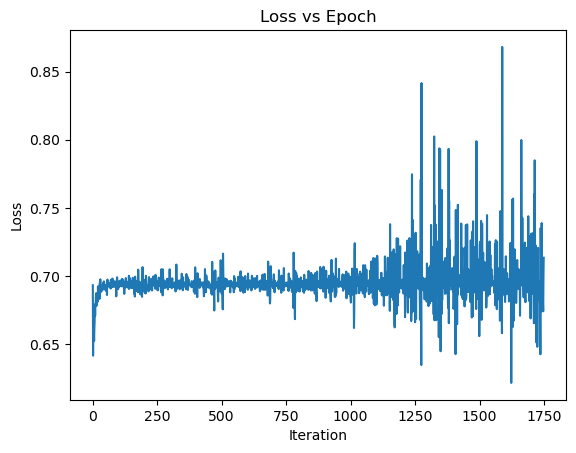

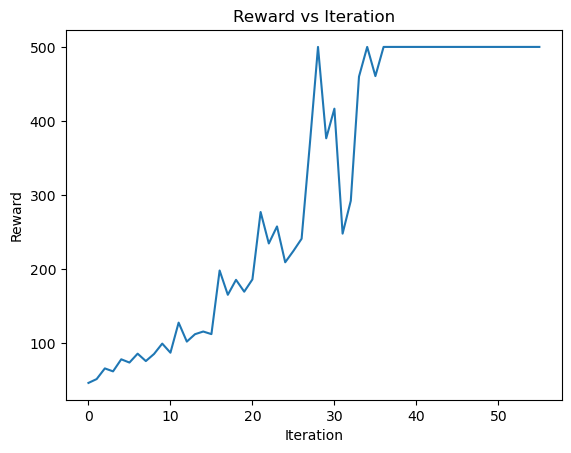

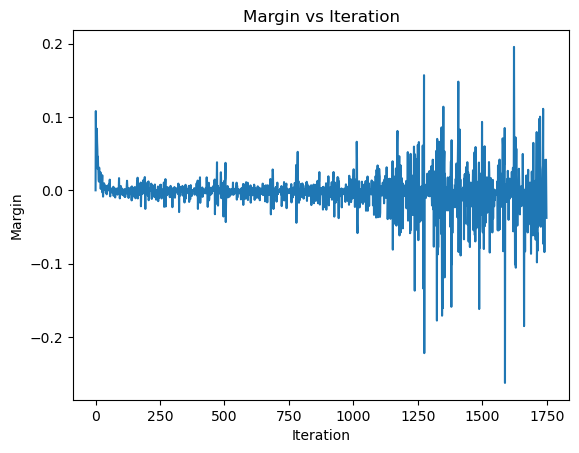

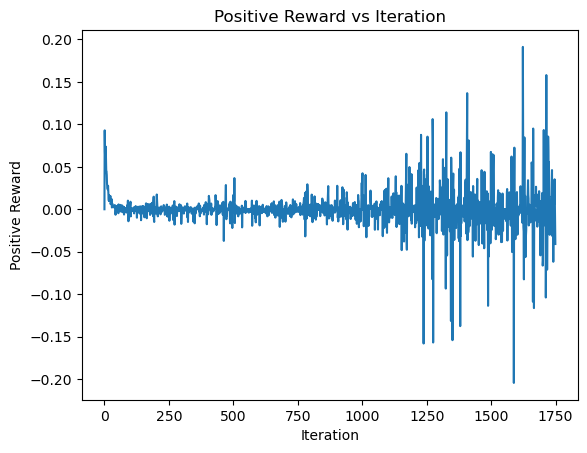

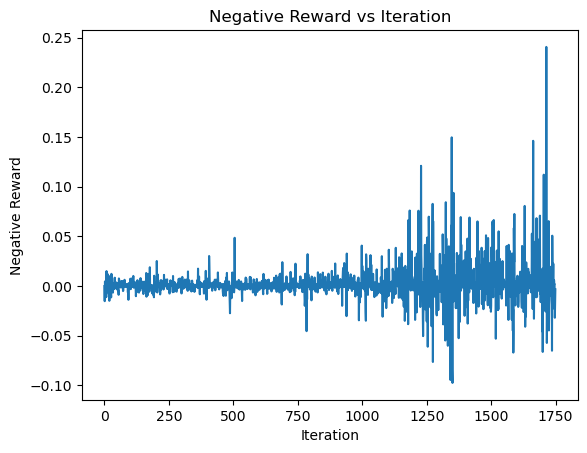

In [24]:
# save all png to /mnt/nfs/work/c98181/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/loss.png")




# draw the reward graph

plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/reward.png")

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/margin.png")

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/positive_reward.png")

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/negative_reward.png")